# Adamawa LGAs

<!-- markdownlint-disable MD013 -->

Compare HNRP targeting and flood exposure for LGAs along Benue in Adamawa.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import ocha_stratus as stratus

from src.datasources import codab, floodscan, hydrosheds
from src.utils import blob
from src.constants import *

## Load data

In [5]:
adm2 = codab.load_codab_from_blob(admin_level=2, aoi_only=True)
adm2_benue = adm2[adm2["ADM2_PCODE"].isin(BENUE_ADM2_PCODES)]

In [6]:
benue = hydrosheds.load_benue_aoi()

In [26]:
fs = floodscan.load_adm2_flood_exposures()
fs_mean = fs.groupby("ADM2_PCODE")["total_exposed"].mean().reset_index()

## Plot

### Basic plot with river

(11.3432261229, 13.2434238751, 8.715484789100001, 9.7776734089)

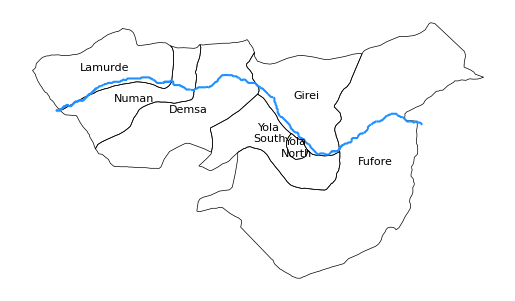

In [8]:
fig, ax = plt.subplots()
adm2_benue.boundary.plot(ax=ax, color="k", linewidth=0.5)
benue.plot(ax=ax, color="dodgerblue")

for name, row in adm2_benue.set_index("ADM2_EN").iterrows():
    y_shift = 0.05 if name == "Yola South" else 0
    x_shift = 0.1 if name == "Fufore" else 0
    ax.annotate(
        "\n".join(name.split(" ")),
        (
            row["geometry"].centroid.x + x_shift,
            row["geometry"].centroid.y + y_shift,
        ),
        fontsize=8,
        ha="center",
        va="center",
    )

ax.axis("off")

## Load HNRP data

CSV from HDX

In [3]:
import src.constants

blob_name = f"{src.constants.PROJECT_PREFIX}/raw/hnrp/hdx_hapi_humanitarian_needs_global_2025_adamawa_intersectoral_total.csv"

In [4]:
df_hnrp = stratus.load_csv_from_blob(blob_name)

In [10]:
pop_status = "TGT"

In [92]:
gdf_compare = adm2_benue.merge(
    df_hnrp[df_hnrp["population_status"] == pop_status].rename(
        columns={"admin2_code": "ADM2_PCODE"}
    ),
    how="left",
).merge(fs_mean)

## More plots

### Population targeted

(11.3432261229, 13.2434238751, 8.715484789100001, 9.7776734089)

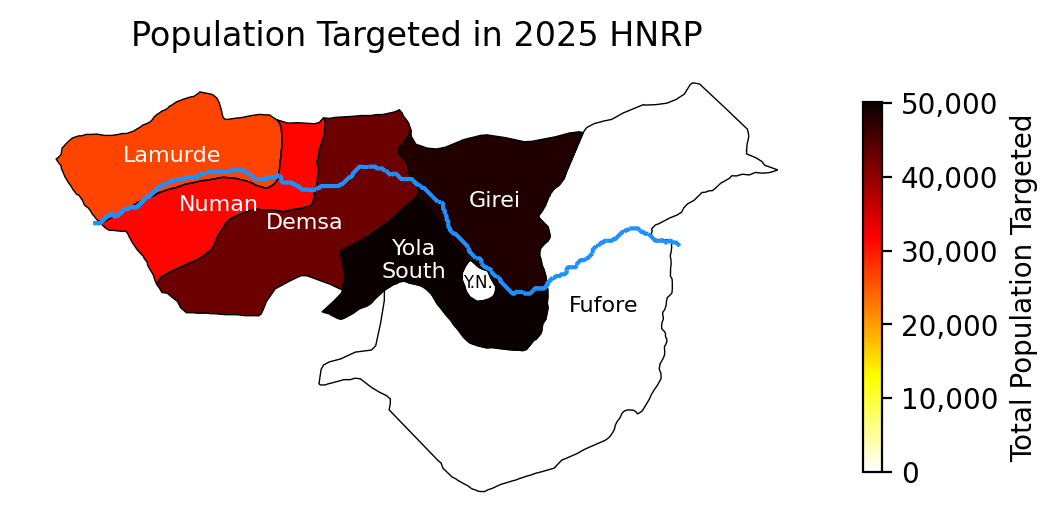

In [145]:
fig, ax = plt.subplots(dpi=200)
gdf_compare.plot(
    column="population",
    ax=ax,
    vmin=0,
    cmap="hot_r",
    legend=True,
    legend_kwds={"label": "Total Population Targeted", "shrink": 0.5},
)
gdf_compare.boundary.plot(ax=ax, color="k", linewidth=0.5)
benue.plot(ax=ax, color="dodgerblue")

for name, row in gdf_compare.set_index("ADM2_EN").iterrows():
    y_shift = 0.05 if name == "Yola South" else 0
    x_shift = 0.1 if name == "Fufore" else 0
    x_shift = -0.05 if name == "Yola South" else x_shift
    name = "Y.N." if name == "Yola North" else name
    ax.annotate(
        "\n".join(name.split(" ")),
        (
            row["geometry"].centroid.x + x_shift,
            row["geometry"].centroid.y + y_shift,
        ),
        fontsize=6 if name == "Y.N." else 8,
        color="w" if row["population"] > 0 else "k",
        ha="center",
        va="center",
    )

cbar = ax.get_figure().axes[-1]  # Get last axis (colorbar)
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

ax.set_title("Population Targeted in 2025 HNRP")

ax.axis("off")

### Population exposed

(11.3432261229, 13.2434238751, 8.715484789100001, 9.7776734089)

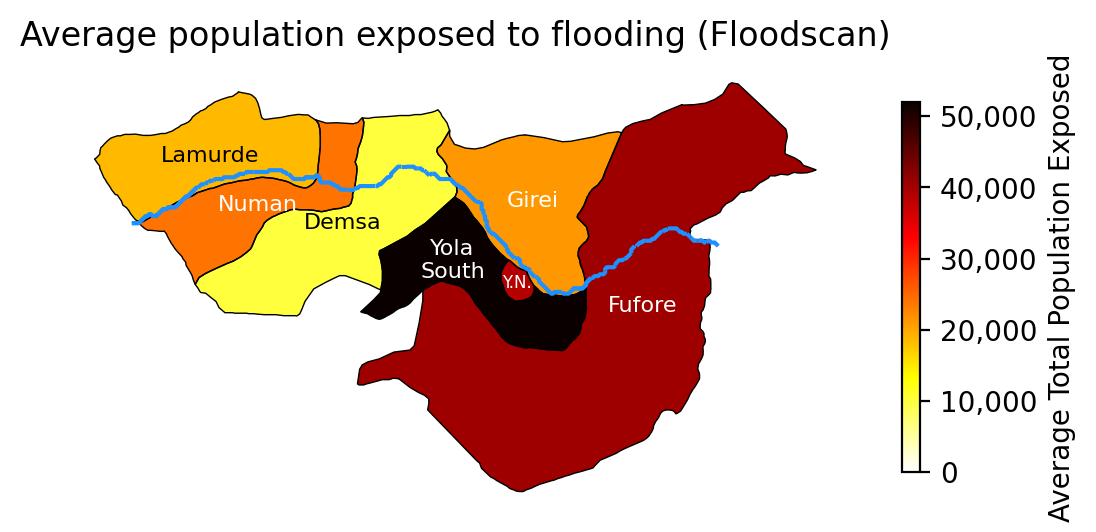

In [147]:
fig, ax = plt.subplots(dpi=200)
gdf_compare.plot(
    column="total_exposed",
    ax=ax,
    vmin=0,
    cmap="hot_r",
    legend=True,
    legend_kwds={"label": "Average Total Population Exposed", "shrink": 0.5},
)
gdf_compare.boundary.plot(ax=ax, color="k", linewidth=0.5)
benue.plot(ax=ax, color="dodgerblue")

for name, row in gdf_compare.set_index("ADM2_EN").iterrows():
    y_shift = 0.05 if name == "Yola South" else 0
    x_shift = 0.1 if name == "Fufore" else 0
    x_shift = -0.05 if name == "Yola South" else x_shift
    name = "Y.N." if name == "Yola North" else name
    ax.annotate(
        "\n".join(name.split(" ")),
        (
            row["geometry"].centroid.x + x_shift,
            row["geometry"].centroid.y + y_shift,
        ),
        fontsize=6 if name == "Y.N." else 8,
        color="w" if row["total_exposed"] > 20000 else "k",
        ha="center",
        va="center",
    )

cbar = ax.get_figure().axes[-1]  # Get last axis (colorbar)
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

ax.set_title("Average population exposed to flooding (Floodscan)")

ax.axis("off")

### Scatter plot comparison

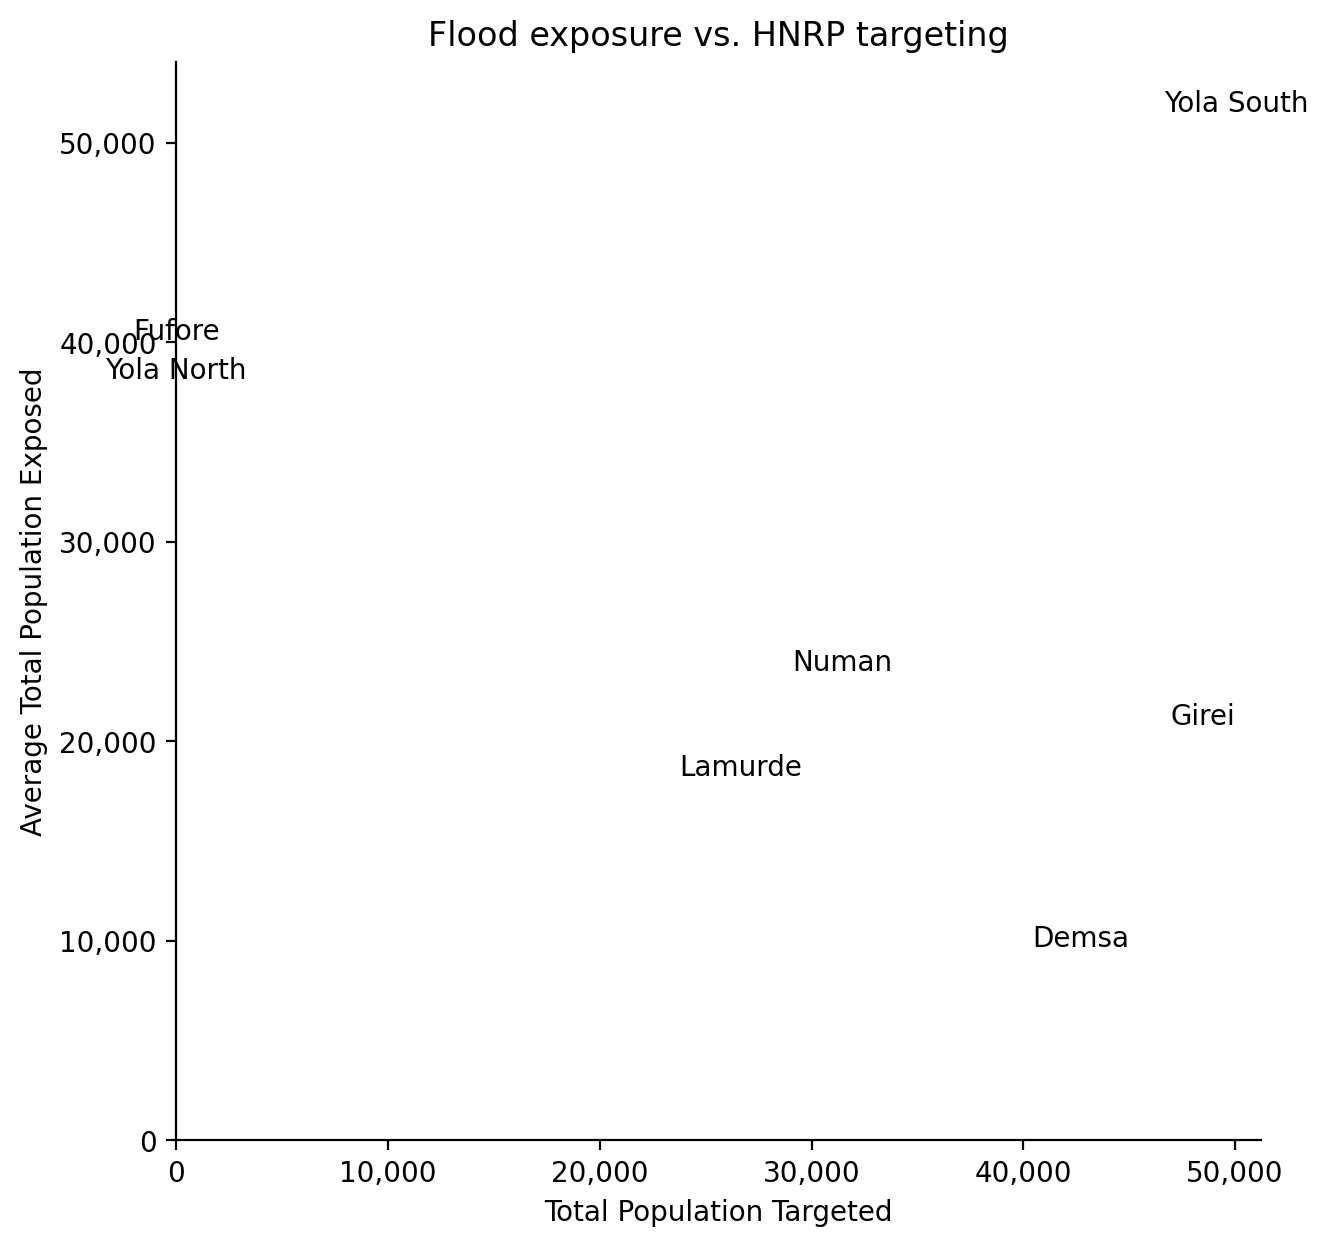

In [148]:
fig, ax = plt.subplots(dpi=200, figsize=(7, 7))
gdf_compare.drop(columns="geometry").plot(
    x="population", y="total_exposed", ax=ax, linewidth=0, legend=False
)

for name, row in gdf_compare.set_index("ADM2_EN").iterrows():
    pop = row["population"] if row["population"] > 0 else 0
    ax.annotate(
        name,
        (pop, row["total_exposed"]),
        ha="center",
        va="center",
    )

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

ax.set_xlabel("Total Population Targeted")
ax.set_ylabel("Average Total Population Exposed")
ax.set_title("Flood exposure vs. HNRP targeting")

ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:,.0f}"))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)